In [3]:
import os
import sys
import glob
import zlib
import math
import copy
import pickle
import pymzml
import importlib.util
import numpy as np
import pandas as pd
import seaborn as sns
import _pickle as cpickle
import matplotlib.pyplot as plt
from importlib import reload
from collections import defaultdict as ddict
from scipy.ndimage.filters import gaussian_filter
from tensorly.decomposition import non_negative_parafac as nnp

#Tensor label-generation constants
hd_mass_diff = 1.006277
c13_mass_diff = 1.00335

#config params
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

sys.path.append(os.getcwd()+"/workflow/scripts/auxiliary/")
import molmass
import hxtools
import LC_IM_MS_TensorAnalysis as hx

library_info = pd.read_csv("resources/library_info/library_info.csv")
library_info['Drift Time MS1'] = library_info['im_mono'] / 200.0 * 13.781163434903 

old_data_dir = "/projects/p30802/digs_old/HX/180604_mix2_MES/hx_fits/"
names_and_seqs = pd.read_csv("resources/library_info/new_HX_order.csv")

(0.97, 1)

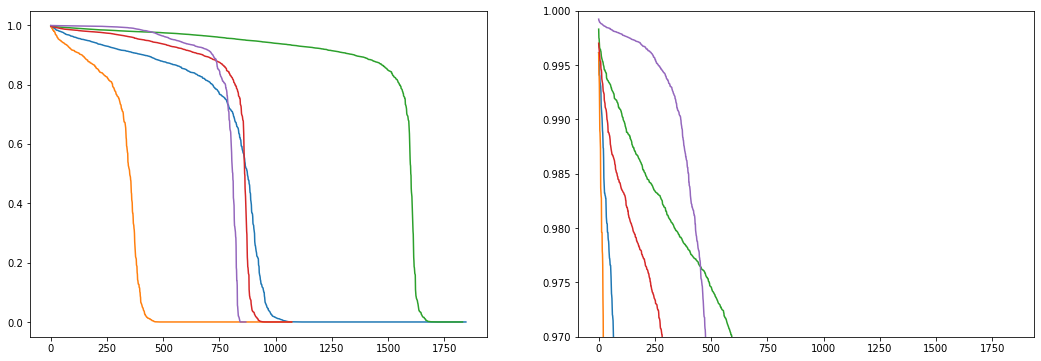

In [4]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')
old_df = old_df.iloc[np.arange(0,len(old_df), 23)]
old_proc_df = pd.read_csv('resources/library_info/idotp_proc_df_9_2020.csv')
idotp_proc = glob.glob("resources/idotp_filter/*")
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values
proc_df['dt'] = [library_info.loc[idx]['im_mono'] / 200.0 * 13.781163434903 for idx in proc_df['index'].values]

old_proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in old_proc_df['name'].values]
proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in proc_df['name'].values]
old_df['name_fix'] = old_df['name']

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.subplot(1,2,2)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.ylim(0.97,1)

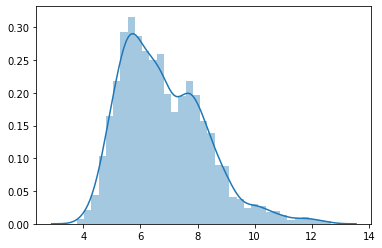

In [56]:
sns.distplot(proc_df['dt'].values)

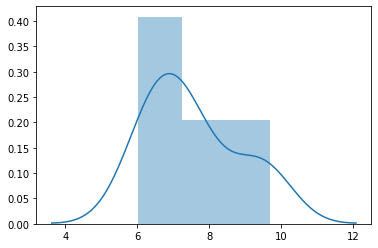

In [57]:
sns.distplot(test['dt'].values)

In [18]:
library_info['Drift Time MS1'] = library_info['im_mono'] / 200.0 * 13.781163434903 
proc_df['new_dt_ubound'] = library_info.iloc[proc_df['index'].values]['Drift Time MS1'].values * (1+0.06)
proc_df['new_dt_lbound'] = library_info.iloc[proc_df['index'].values]['Drift Time MS1'].values * (1-0.06)
old_df['old_dt_ubound'] = old_df['input_DTs'].values * (1+0.06)
old_df['old_dt_lbound'] = old_df['input_DTs'].values * (1-0.06)

In [54]:
mrg = old_df.merge(proc_df, on='name_fix')
mrg['idotp_diff'] = [x-y for x, y in zip(mrg['idotp'].values, mrg['fit_to_theo_dist'].values)] #negative diff is worse for new
mrg['rt_diff'] = [x-y for x, y in zip(mrg['rt'].values, mrg['input_RTs'].values)] #higher is worse
mrg['dt_diff'] = [x-y for x, y in zip(mrg['dt'], mrg['input_DTs'])]
mrg['ubound_diff'] = [x-y for x, y in zip(mrg['new_dt_ubound'].values, mrg['old_dt_ubound'].values)]
mrg['lbound_diff'] = [x-y for x, y in zip(mrg['new_dt_lbound'].values, mrg['old_dt_lbound'].values)]
mrg['ubound_diff_bins'] = mrg['ubound_diff'] * 200 / 13.781163434903
mrg['lbound_diff_bins'] = mrg['lbound_diff'] * 200 / 13.781163434903
mrg = mrg.loc[mrg['charge_x'] == mrg['charge_y']]
mrg = mrg.sort_values(['rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, False, False])

In [52]:
test = mrg.loc[mrg['fit_to_theo_dist'] > 0.99]
test = test.loc[abs(test['idotp_diff']) > 0.1]
test = test.loc[test['rt_diff'] < 0.1]
#test = test.loc[test['dt_diff'] < 0.3]

In [45]:
test.sort_values(['dt_diff', 'rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, True, False, False])[['index', 'dt_diff', 'dt', 'rt_diff', 'idotp', 'fit_to_theo_dist', 'idotp_diff']]

,index,dt_diff,dt,rt_diff,idotp,fit_to_theo_dist,idotp_diff
3266,1555,0.079069,6.015114,0.099076,0.000000,0.998339,-0.998339
305,1790,0.110309,6.607142,0.089258,0.000586,0.998301,-0.997715
5616,639,0.138163,6.579289,0.079665,0.493862,0.997932,-0.504070
6036,557,0.146353,9.687442,0.015284,0.034037,0.995555,-0.961518
9722,1923,0.155912,9.193118,0.021857,0.000038,0.995937,-0.995899
2072,2026,1.171287,7.415971,0.045932,0.038927,0.998671,-0.959743
10746,842,1.420752,7.789774,0.090027,0.000000,0.996254,-0.996254
8496,617,1.612508,6.974749,0.016638,0.081541,0.990667,-0.909126


In [63]:
i = 1555 #1836 #557

In [64]:
ins = glob.glob("resources/tensors/"+str(i)+"_*UN*")

In [65]:
#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq=seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)

#find rt_group undeut tensors
undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
DTs = []
for fn in ins:
    #read mzml 
    print("Loop: "+str(count)+", Debug 1")
    output = hx.limit_read(fn)
    print("Loop: "+str(count)+", Debug 2")
    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts = output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )
    print("Loop: "+str(count)+", Debug 3")
    print("Tensor Dims: "+str(np.shape(newDataTensor.full_grid_out)))
    
    newDataTensor.lows = np.searchsorted(newDataTensor.mz_labels, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_labels, high_lims)
    newDataTensor.factorize()
    DTs.append(newDataTensor)
    print("Loop: "+str(count)+", Debug 4")
    #Hacky, clean
    [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
    
    print("Loop: "+str(count)+", Debug 5")
    count += 1

for ic in undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states))

if len(dot_products) > 0:
    best_idotp = max(np.asarray(dot_products)[:,0])
else:
    best_idotp = 0

print("Debug: Loop Complete")

pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]})

Debug: Start undeut factorizations
Loop: 1, Debug 1
Loop: 1, Debug 2
Loop: 1, Debug 3
Tensor Dims: (47, 11, 618)
Beginning Factorization...
All n-factors failed for Index: HHH_rd3_0081.pdb_9.07449, keeping 1 factor decomposition.
Done: T+85.04880094528198
Loop: 1, Debug 4
Loop: 1, Debug 5
Loop: 2, Debug 1
Loop: 2, Debug 2
Loop: 2, Debug 3
Tensor Dims: (47, 11, 618)
Beginning Factorization...
All n-factors failed for Index: HHH_rd3_0081.pdb_9.07449, keeping 1 factor decomposition.
Done: T+85.77161741256714
Loop: 2, Debug 4
Loop: 2, Debug 5
Loop: 3, Debug 1
Loop: 3, Debug 2
Loop: 3, Debug 3
Tensor Dims: (47, 11, 618)
Beginning Factorization...
All n-factors failed for Index: HHH_rd3_0081.pdb_9.07449, keeping 1 factor decomposition.
Done: T+85.55823826789856
Loop: 3, Debug 4
Loop: 3, Debug 5
Debug: Loop Complete


,index,name,charge,idotp
0,1555,HHH_rd3_0081.pdb_9.07449,6.0,0.0


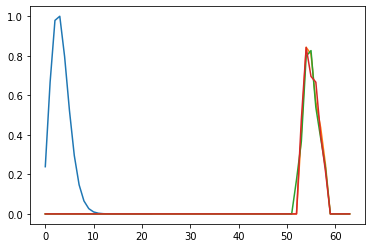

In [66]:
plt.plot(hx_prot.isotope_dist)
for ic in undeut_ics:
    plt.plot(ic.baseline_integrated_mz)

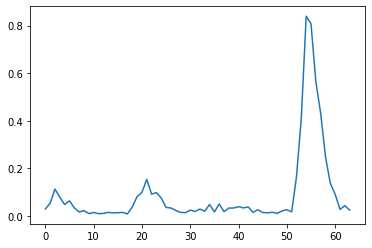

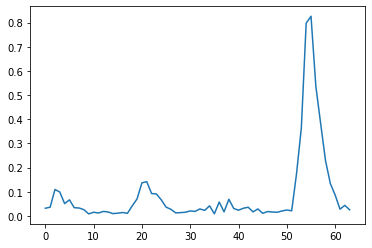

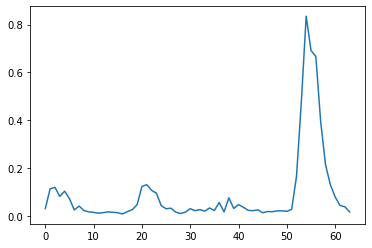

In [67]:
for dt in DTs:
    plt.figure()
    for factor in dt.factors:
        plt.plot(factor.integrated_mz_data)

In [68]:
undeut_ics[0].abs_mz_com * undeut_ics[0].charge_states[0]

5497.932953834787

In [69]:
molmass.analyze(molmass.from_peptide(hx_prot.sequence)).split('\n')[3].split()[-1]

'5436.6717'

In [99]:
len(proc_df)

4310

In [100]:
len(old_df)

2123

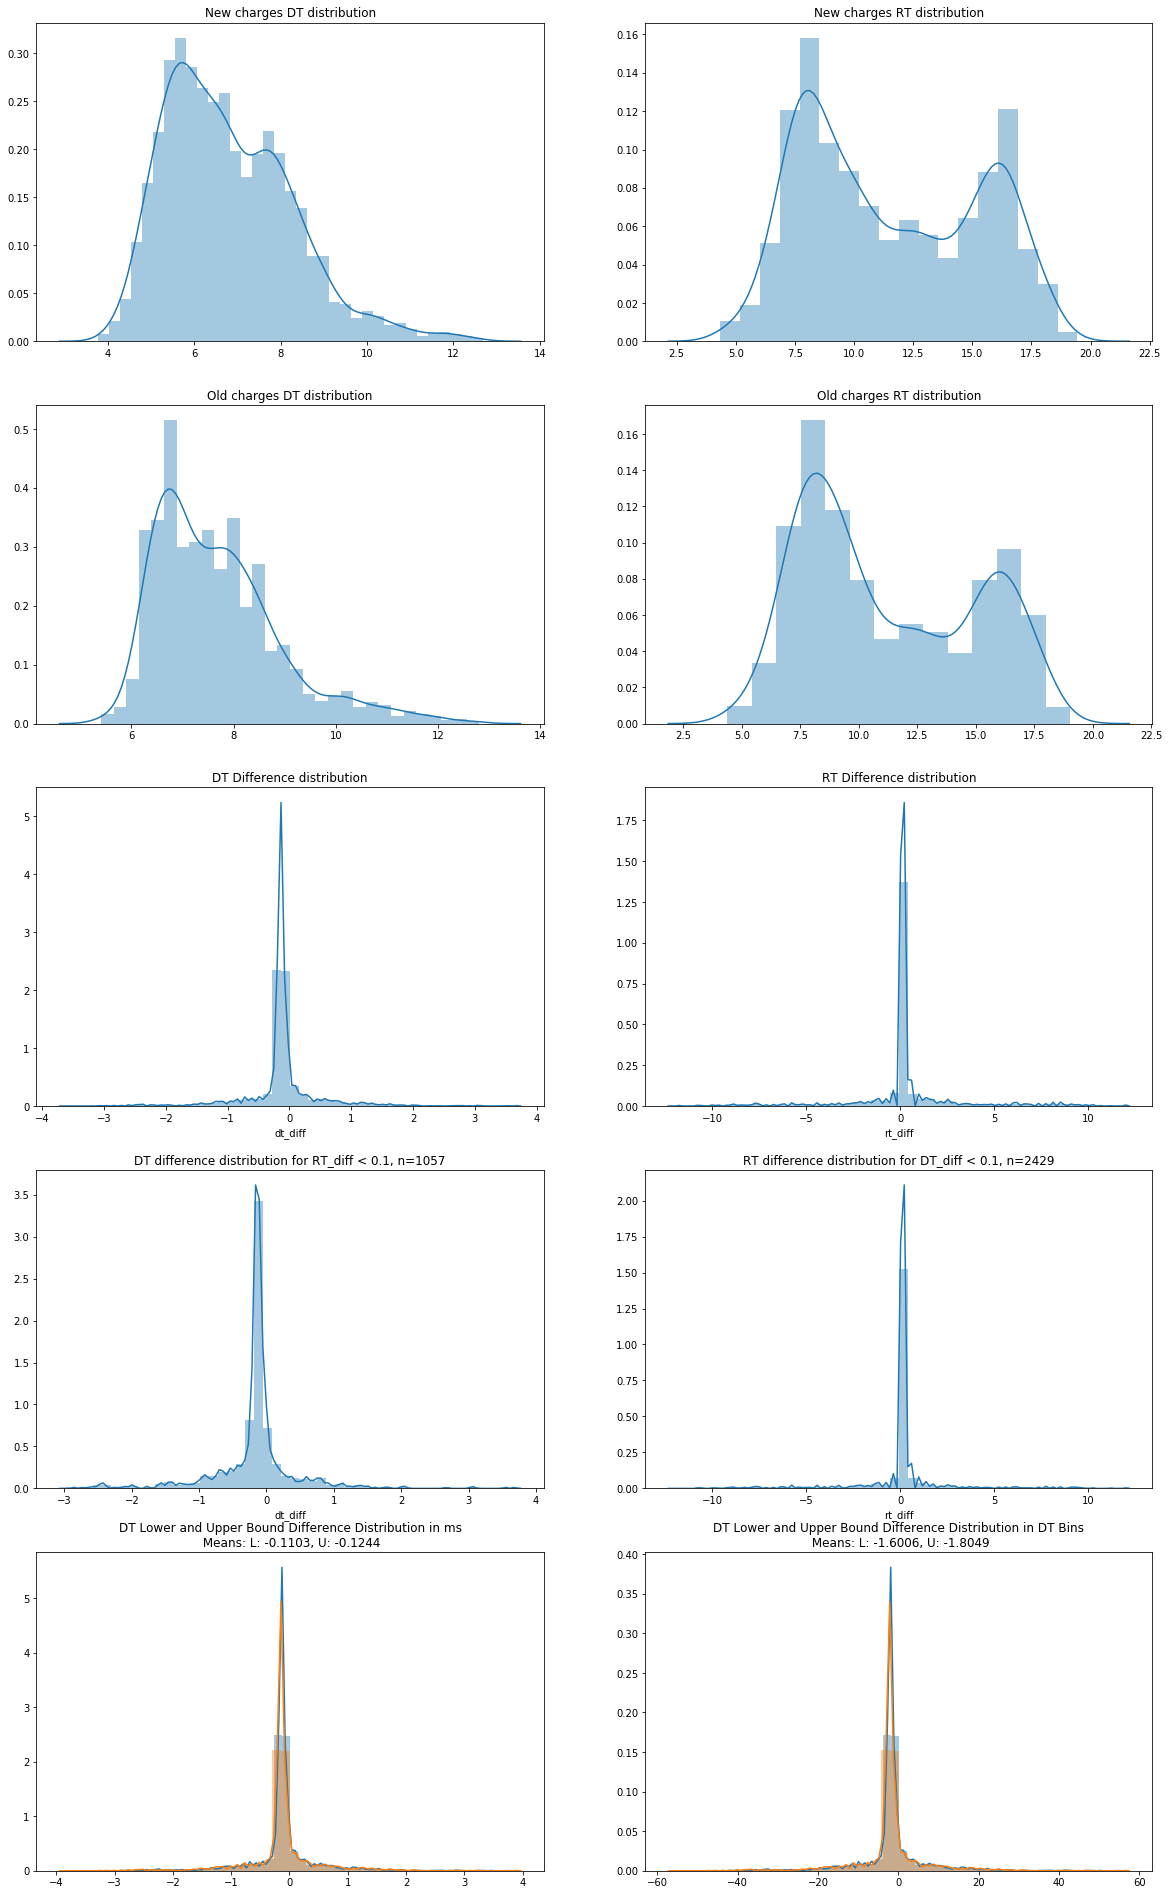

In [55]:
fig = plt.figure(figsize=(20,34))
ax1 = fig.add_subplot(521)
ax1.title.set_text('New charges DT distribution')
sns.distplot(proc_df['dt'].values)
ax2 = plt.subplot(523)
ax2.title.set_text('Old charges DT distribution')
sns.distplot(old_df['input_DTs'].values)
ax3 = plt.subplot(522)
ax3.title.set_text('New charges RT distribution')
sns.distplot(proc_df['rt'].values)
ax4 = plt.subplot(524)
ax4.title.set_text('Old charges RT distribution')
sns.distplot(old_df['input_RTs'].values)
ax5 = plt.subplot(525)
ax5.title.set_text('DT Difference distribution')
sns.distplot(mrg['dt_diff'])
ax6 = plt.subplot(526)
ax6.title.set_text('RT Difference distribution')
sns.distplot(mrg['rt_diff'])
ax7 = plt.subplot(527)
ax7.title.set_text('DT difference distribution for RT_diff < 0.1, n='+str(len(mrg.loc[mrg['rt_diff'] < 0.1]['dt_diff'])))
sns.distplot(mrg.loc[mrg['rt_diff'] < 0.1]['dt_diff'])
ax8 = plt.subplot(528)
ax8.title.set_text('RT difference distribution for DT_diff < 0.1, n='+str(len(mrg.loc[mrg['dt_diff'] < 0.1]['rt_diff'])))
sns.distplot(mrg.loc[mrg['dt_diff'] < 0.1]['rt_diff'])
ax9 = plt.subplot(529)
ax9.title.set_text('DT Lower and Upper Bound Difference Distribution in ms\n Means: L: '+str(np.round(np.mean(mrg['lbound_diff'].values), 4))+", U: "+str(np.round(np.mean(mrg['ubound_diff'].values), 4)))
sns.distplot(mrg['lbound_diff'].values)
sns.distplot(mrg['ubound_diff'].values)
ax10 = plt.subplot(5,2,10)
ax10.title.set_text('DT Lower and Upper Bound Difference Distribution in DT Bins\n Means: L: '+str(np.round(np.mean(mrg['lbound_diff_bins'].values), 4))+", U: "+str(np.round(np.mean(mrg['ubound_diff_bins'].values), 4)))
sns.distplot(mrg['lbound_diff_bins'].values)
sns.distplot(mrg['ubound_diff_bins'].values)
plt.savefig('9_14_dist_comparison.png')

In [2]:
zuns = sorted(glob.glob("resources/tensors/0_*UN*"))

In [5]:
data = hx.limit_read(zuns[0])

In [ ]:
hx.DataTensor(source_file = zuns[0],
        tensor_idx = 0, 
        timepoint_idx = 0, 
        name = library_info.iloc[0]['name'], 
        total_mass_window,
        n_concatenated,
        charge_states,data[0], data[1], data[2])

**IDOTP CHECK**

In [ ]:
#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq=seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)

#find rt_group undeut tensors
undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
for fn in zuns:
    #read mzml 
    print("Loop: "+str(count)+", Debug 1")
    output = hx.limit_read(fn)
    print("Loop: "+str(count)+", Debug 2")
    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts = output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )
    print("Loop: "+str(count)+", Debug 3")
    print("Tensor Dims: "+str(np.shape(newDataTensor.full_grid_out)))
    
    newDataTensor.lows = np.searchsorted(newDataTensor.mz_labels, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_labels, high_lims)
    newDataTensor.factorize()
    print("Loop: "+str(count)+", Debug 4")
    #Hacky, clean
    [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

    print("Loop: "+str(count)+", Debug 5")
    count += 1

for ic in undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states))

if len(dot_products) > 0:
    best_idotp = max(np.asarray(dot_products)[:,0])
else:
    best_idotp = 0

print("Debug: Loop Complete")

pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]})

Debug: Start undeut factorizations
Loop: 1, Debug 1
Loop: 1, Debug 2
Loop: 1, Debug 3
Tensor Dims: (47, 14, 751)
Beginning Factorization...


In [9]:
%debug

> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)<listcomp>()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  x


array([], shape=(0, 2), dtype=float32)


ipdb>  sparse_data


*** NameError: name 'sparse_data' is not defined


ipdb>  sparse_data


*** NameError: name 'sparse_data' is not defined


ipdb>  self.rts


*** NameError: name 'self' is not defined


ipdb>  self


*** NameError: name 'self' is not defined


ipdb>  u


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)sparse_to_full_tensor()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  self


ipdb>  sparse_data


array([array([[1142.1599,   39.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1130.0481,   34.    ],
       [1130.0629,   74.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1132.339,   45.   ]], dtype=float32),
       array([[1133.6764,   27.    ]], dtype=float32),
       array([[1136.7952,   30.    ],
       [1136.8099,   45.    ],
       [1139.9476,   33.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1138.1647,   55.    ],
       [1138.1793,   26.    ]], dtype=float32),
       array([[1131.1492,   45.    ]], dtype=float32),
       array([], shape=

ipdb>  len(sparse_data)


658


ipdb>  u


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(221)__init__()
    219             """
    220 
--> 221             self.retention_labels, self.drift_labels, self.mz_labels, self.min_mz, self.max_mz, self.full_grid_out = self.sparse_to_full_tensor((self.rts, self.dts, self.seq_out))
    222             self.full_gauss_grids = self.gauss(self.full_grid_out)
    223 



ipdb>  d


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)sparse_to_full_tensor()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  quit


In [3]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')

old_proc_df = pd.read_csv('resources/library_info/idotp_proc_df_9_2020.csv')

In [2]:
#make table of all new charges and find matching old charge rt(s?, probably was filtering for single cluster/charge from naming conventions)

In [8]:
proc_df.columns

Index(['Unnamed: 0', 'index', 'name', 'charge', 'idotp', 'rt'], dtype='object')

In [9]:
proc_df.sort_values(['rt', 'idotp'])

,Unnamed: 0,index,name,charge,idotp,rt
0,0,0,HHH_rd4_0891.pdb_4.33802,5.0,9.646407e-01,4.349178
4,0,4,HEEH_rd1_0125.pdb_4.41988,4.0,8.268960e-01,4.383614
10,0,10,HEEH_rd3_0224.pdb_4.43963,7.0,8.484195e-09,4.400998
6,0,6,HEEH_rd1_0125.pdb_4.41988,6.0,8.761886e-01,4.439518
2,0,2,HEEH_rd1_0966.pdb_4.37754,6.0,8.813491e-01,4.453601
...,...,...,...,...,...,...
4308,0,4309,HEEH_rd4_0276.pdb_18.72244,7.0,0.000000e+00,18.967132
4307,0,4308,HEEH_rd4_0276.pdb_18.72244,6.0,0.000000e+00,18.989288
4313,0,4314,HHH_rd4_0269.pdb_18.98777,5.0,9.591543e-01,19.004371
4312,0,4313,HEEH_rd4_0246.pdb_18.86922,6.0,8.163959e-01,19.109474


In [13]:
proc_df[['name', 'rt']].values[0][0]

'HHH_rd4_0891.pdb_4.33802'

In [4]:
proc_df['rt_group_diff'] = [tup[1] - float(tup[0].split('_')[-1]) for tup in proc_df[['name','rt']].values]

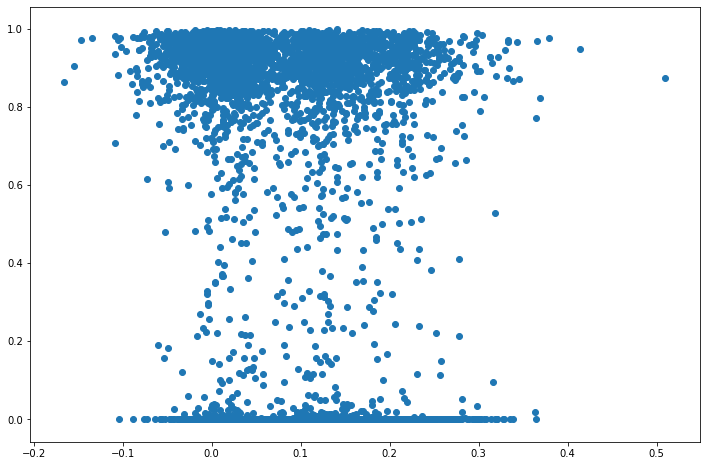

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(list(proc_df.sort_values('rt_group_diff')['rt_group_diff'].values), list(proc_df.sort_values('rt_group_diff')['idotp'].values))

In [15]:
old_df.columns

Index(['Unnamed: 0', 'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [34]:
old_undeut_df = old_df.iloc[[j for i in np.arange(0,len(old_df), 23) for j in range(i,i+3)]]

In [35]:
proc_df['old'] = [0 for i in range(len(proc_df))]
old_undeut_df['old'] = [1 for i in range(len(old_undeut_df))]

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
proc_df['name_fix'] = ['_'.join(name.split('_')[:-1]) for name in proc_df['name'].values]

In [87]:
proc_df['rt_group_avg'] = [float(name.split('_')[-1]) for name in proc_df['name'].values]

In [49]:
old_undeut_df['name_fix'] = list(old_undeut_df['name'].values)

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
cdf = proc_df.merge(old_undeut_df, on='name_fix' )

In [82]:
cdf.columns

Index(['Unnamed: 0_x', 'index', 'name_x', 'charge_x', 'idotp', 'rt',
       'rt_group_diff', 'old_x', 'name_fix', 'rt_group_avg', 'Unnamed: 0_y',
       'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name_y', 'charge_y',
       'major_species_widths', 'fit_to_theo_dist', 'old_y'],
      dtype='object')

In [89]:
charge_matches = cdf.loc[cdf['charge_x'] == cdf['charge_y']]

In [90]:
charge_matches['old_rt_diff'] = [abs(charge_matches.iloc[i]['rt_group_avg'] - charge_matches.iloc[i]['input_RTs']) for i in range(len(charge_matches))]

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
charge_matches.sort_values(['rt', 'name_x', 'charge_x', 'old_rt_diff', 'rt_group_diff',])

,Unnamed: 0_x,index,name_x,charge_x,idotp,rt,rt_group_diff,old_x,name_fix,rt_group_avg,...,major_species_centroid,interference_height_ratio,interference_integral_ratio,max_interference_integral_ratio,name_y,charge_y,major_species_widths,fit_to_theo_dist,old_y,old_rt_diff
1,0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641,4.349178,0.011158,0,HHH_rd4_0891.pdb,4.33802,...,2.580339,0.210290,0.237726,0.259399,HHH_rd4_0891.pdb,5,8,0.958226,1,0.000430
0,0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641,4.349178,0.011158,0,HHH_rd4_0891.pdb,4.33802,...,2.514853,0.183812,0.259399,0.259399,HHH_rd4_0891.pdb,5,7,0.958226,1,0.034247
2,0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641,4.349178,0.011158,0,HHH_rd4_0891.pdb,4.33802,...,2.513623,0.111394,0.234696,0.259399,HHH_rd4_0891.pdb,5,7,0.958226,1,0.135680
4,0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641,4.349178,0.011158,0,HHH_rd4_0891.pdb,4.33802,...,5.605512,0.087165,0.244685,0.743382,HHH_rd4_0891.pdb,5,11,0.721479,1,5.238930
3,0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641,4.349178,0.011158,0,HHH_rd4_0891.pdb,4.33802,...,5.567468,0.076315,0.272614,0.743382,HHH_rd4_0891.pdb,5,10,0.721479,1,5.256214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31324,0,4313,HEEH_rd4_0246.pdb_18.86922,6.0,0.816396,19.109474,0.240254,0,HEEH_rd4_0246.pdb,18.86922,...,2.933230,0.720670,1.352218,1.372103,HEEH_rd4_0246.pdb,6,7,0.990828,1,0.018186
31325,0,4313,HEEH_rd4_0246.pdb_18.86922,6.0,0.816396,19.109474,0.240254,0,HEEH_rd4_0246.pdb,18.86922,...,2.978854,0.223020,0.866788,1.372103,HEEH_rd4_0246.pdb,6,7,0.990828,1,0.273230
31322,0,4313,HEEH_rd4_0246.pdb_18.86922,6.0,0.816396,19.109474,0.240254,0,HEEH_rd4_0246.pdb,18.86922,...,3.000631,0.108068,0.612531,2.571534,HEEH_rd4_0246.pdb,6,7,0.979808,1,2.423837
31321,0,4313,HEEH_rd4_0246.pdb_18.86922,6.0,0.816396,19.109474,0.240254,0,HEEH_rd4_0246.pdb,18.86922,...,2.944223,0.090663,0.495855,2.571534,HEEH_rd4_0246.pdb,6,7,0.979808,1,2.509187


In [92]:
best_charge_matches = charge_matches.drop_duplicates(['name_x','charge_x'])

In [107]:
best_charge_matches.to_csv('resources/library_info/09_2020_idotp_comparison.csv')

In [102]:
best_charge_matches['idotp_diff'] = best_charge_matches['idotp'] - best_charge_matches['fit_to_theo_dist'] #negative is worse

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
best_charge_matches['idotp_diff']

0        0.006415
12      -0.060355
24      -0.078419
45      -0.036281
75      -0.022555
           ...   
32853   -0.055225
32874   -0.011206
32883   -0.025757
32895   -0.078690
32910   -0.995894
Name: idotp_diff, Length: 2080, dtype: float64

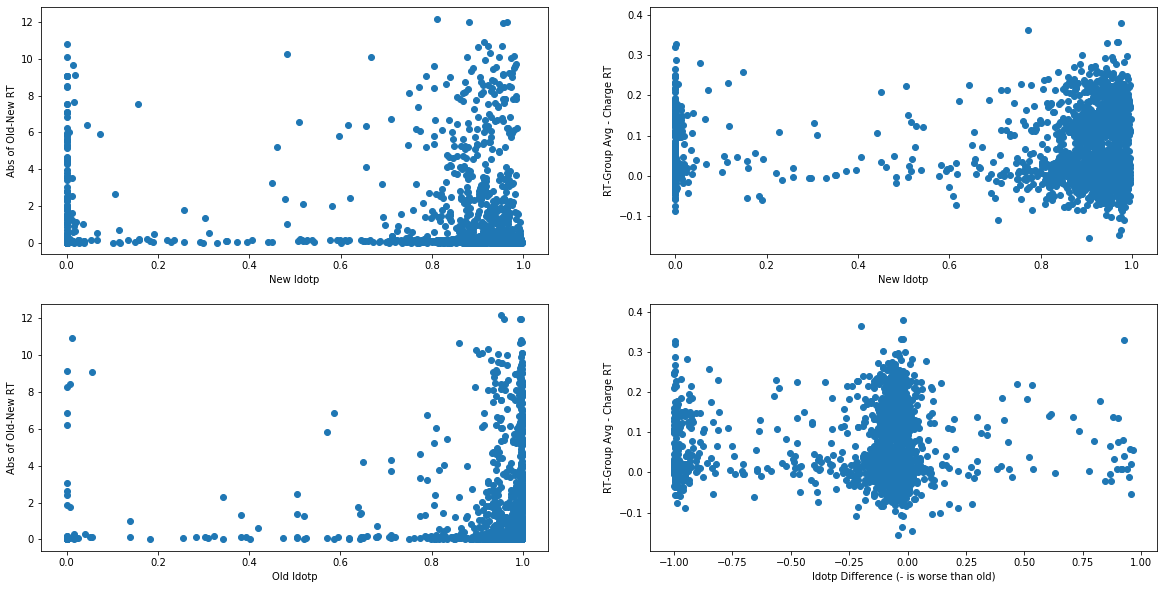

In [106]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.scatter(list(best_charge_matches.sort_values('old_rt_diff')['idotp'].values), list(best_charge_matches.sort_values('old_rt_diff')['old_rt_diff'].values))
plt.xlabel('New Idotp')
plt.ylabel('Abs of Old-New RT')
plt.subplot(2,2,2)
plt.scatter(list(best_charge_matches.sort_values('rt_group_diff')['idotp'].values), list(best_charge_matches.sort_values('rt_group_diff')['rt_group_diff'].values))
plt.xlabel('New Idotp')
plt.ylabel('RT-Group Avg - Charge RT')
plt.subplot(2,2,3)
plt.scatter(list(best_charge_matches.sort_values('old_rt_diff')['fit_to_theo_dist'].values), list(best_charge_matches.sort_values('old_rt_diff')['old_rt_diff'].values))
plt.xlabel('Old Idotp')
plt.ylabel('Abs of Old-New RT')
plt.subplot(2,2,4)
plt.scatter(list(best_charge_matches.sort_values('rt_group_diff')['idotp_diff'].values), list(best_charge_matches.sort_values('rt_group_diff')['rt_group_diff'].values))
plt.xlabel('Idotp Difference (- is worse than old)')
plt.ylabel('RT-Group Avg - Charge RT')
plt.show()
plt.close()

In [18]:
new_names = list(proc_df.sort_values('name')['name'].values)
new_rts = list(proc_df.sort_values('name')['rt'].values)
new_charges = list(proc_df.sort_values('name')['charge'].values)
new_rt_dict = ddict.fromkeys(new_names)
for key in new_rt_dict:
    new_rt_dict[key] = []
for key, value in zip(new_names, new_rts):
    new_rt_dict[key].append(value)

old_undeut_names = [old_df.iloc[i]['name'] for i in np.arange(0,len(old_df),23)]
old_undeut_charges = [list(old_df.iloc[i:i+3]['charge'].values) for i in np.arange(0,len(old_df),23)]
old_undeut_rts = [list(old_df.iloc[i:i+3]['input_RTs'].values) for i in np.arange(0,len(old_df),23)]
old_undeut_intensities = [list(old_df.iloc[i:i+3]['major_species_total_intensity'].values) for i in np.arange(0,len(old_df),23)]

old_rt_dict = ddict.fromkeys(old_undeut_names)
for key, rt, charge, intensity in zip(old_undeut_names, old_undeut_rts, old_undeut_charges, old_undeut_intensity):
    old_rt_dict[key] = pd.DataFrame().from_dict({})

KeyError: 's'

In [11]:
#for each rt-group, finds all old charge rts, pairwise abs diff by index of charge rt in rt-group
comparison_map = ddict.fromkeys(new_rt_dict.keys())
for key in new_rt_dict.keys():
    search_key = '_'.join(key.split('_')[:-1])
    if search_key in old_rt_dict.keys():
        if any([any([abs(rt-new_rt) < 0.1 for rt in old_rt_dict[search_key]]) for new_rt in new_rt_dict[key]]):
            comparison_map.append([[abs(rt-new_rt) for rt in old_rt_dict[search_key]] for new_rt in new_rt_dict[key]])
        else:
            comparison_map.append([[] for rt in new_rt_dict[key]])

In [12]:
comparison_map

[[[0.14868472403606248, 0.1655847840360618, 0.06415150403606162],
  [0.0732606174012771, 0.09016067740127642, 0.011272602598723758],
  [0.027791952009568632, 0.04469201200956796, 0.05674126799043222],
  [0.00650647199376575, 0.010393588006233578, 0.0910396919937666]],
 [[]],
 [[]],
 [[], []],
 [[], [], [], []],
 [[0.07984848265360078, 0.07984848265360078, 0.00493459734639945],
  [0.07201411726408313, 0.07201411726408313, 0.0127689627359171],
  [0.06880162406291657, 0.06880162406291657, 0.015981455937083666]],
 [[]],
 [[0.14434334384622272, 0.14436003384622254, 0.056710213846222324],
  [0.030158882899637085, 0.030175572899636904, 0.05747424710036331],
  [0.0707768734791916, 0.07079356347919141, 0.0168562565208088],
  [0.10243475517820766, 0.10245144517820748, 0.014801625178207267]],
 [[0.008286225012308357, 0.025186285012308574, 0.07649685498769276],
  [0.036366944230747045, 0.05326700423074726, 0.048416135769254076]],
 [[]],
 [[0.1239343887834865, 0.14085113878348654, 0.039150828783486

In [126]:
#all old names are covered (this does not prove all old charges are covered, requires inverse check), some by multiple rt-groups
len(old_rt_dict.keys()), len([x for x in comparison_map if x != [[]]]) 

(868, 1007)

In [158]:
cm = comparison_map

In [153]:
#shows coverage of old charges by rt-difference cutoff
count = 0
for key in old_rt_dict.keys():
    fix_new_keys = ['_'.join(new.split('_')[:-1]) for new in new_rt_dict.keys()]
    if key in fix_new_keys:
        match_keys = [new_key for new_key in new_rt_dict.keys() if key in new_key]
        if any([any([abs(new_rt - old_rt) < 0.01 for new_rt in new_rt_dict[match_key] for old_rt in old_rt_dict[key]]) for match_key in match_keys]):
            count+=1

count/868

In [87]:
count = 0
for name, rt in new_rts:
    search_name = "_".join(name.split("_")[:-1])
    if search_name in old_rt_dict.keys():
        if any([abs(old_rt - rt) < 0.1 for old_rt in old_rt_dict[search_name]]):
            count += 1    

In [52]:
len(old_undeut_rts), len(old_undeut_rts[0])

(2123, 3)

In [34]:
len(new_rts), len(old_rts)/23

(4315, 2123.0)

In [50]:
old_df.columns

Index(['Unnamed: 0', 'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [49]:
old_df['name', ].values

array(['HEEH_rd2_0682.pdb', 'HEEH_rd2_0682.pdb', 'HEEH_rd2_0682.pdb', ...,
       'HHH_rd2_0018.pdb', 'HHH_rd2_0018.pdb', 'HHH_rd2_0018.pdb'],
      dtype=object)

In [45]:
old_undeut_rts[0][2]

6.82969999

In [ ]:
old_undeut_rts = np.asarray(old_df['input_RTs'].values)

In [ ]:
proc_df['old_rt_diff'] = 

In [23]:
proc_df.sort_values('name')[['idotp'].values

array(['EEHEE_rd1_0123.pdb_6.52278', 'EEHEE_rd1_0229.pdb_4.71485',
       'EEHEE_rd1_0229.pdb_4.71485', ..., 'HHH_rd4_1000.pdb_7.66427',
       'HHH_rd4_1000.pdb_9.04626', 'HHH_rd4_1000.pdb_9.04626'],
      dtype=object)

In [15]:
old_df.columns

Index(['output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [19]:
old_df.sort_values('input_RTs')['input_RTs'].values[0]

4.23701668

In [3]:
alt_lib_info = pd.read_csv("../hdx_pipeline_runs/180604_Mix2_MES_nonlin/data/library_info/library_info.csv")

In [4]:
len(alt_lib_info)

4311

In [5]:
#the only tensor to fail at 16GB
ins = "resources/tensors/852_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib, resources/tensors/852_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib, resources/tensors/852_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib".split(', ')

In [12]:
i = int(ins[0].split('/')[-1].split('_')[0])

hd_mass_diff = 1.006277
c13_mass_diff = 1.00335
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq=seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)



#find rt_group undeut tensors
#undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
for fn in ins:
    #read mzml 
    print("Loop: "+str(count)+", Debug 1")
    output = hx.limit_read(fn)
    print("Loop: "+str(count)+", Debug 2")
    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts= output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )
    print("Loop: "+str(count)+", Debug 3")
    print("Tensor Dims: "+str(np.shape(newDataTensor.full_grid_out)))
    
    newDataTensor.lows = np.searchsorted(newDataTensor.mz_bins, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_bins, high_lims)
    newDataTensor.factorize()
    print("Loop: "+str(count)+", Debug 4")
    #Hacky, clean
    [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

    print("Loop: "+str(count)+", Debug 5")
    count += 1

for ic in undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states))

if len(dot_products) > 0:
	best_idotp = max(np.asarray(dot_products)[:,0])
else:
	best_idotp = 0

print("Debug: Loop Complete")

display(pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]}))
display(old_c)

Debug: Start undeut factorizations
Loop: 1, Debug 1
Loop: 1, Debug 2
Loop: 1, Debug 3
Tensor Dims: (47, 1, 1224)
Beginning Factorization...
Done: T+20.727168560028076
Loop: 1, Debug 4
Loop: 1, Debug 5
Loop: 2, Debug 1
Loop: 2, Debug 2
Loop: 2, Debug 3
Tensor Dims: (47, 1, 1222)
Beginning Factorization...
Done: T+20.27945566177368
Loop: 2, Debug 4
Loop: 2, Debug 5
Loop: 3, Debug 1
Loop: 3, Debug 2
Loop: 3, Debug 3
Tensor Dims: (47, 1, 1158)
Beginning Factorization...
Done: T+18.483741283416748
Loop: 3, Debug 4
Loop: 3, Debug 5
Debug: Loop Complete


,index,name,charge,idotp
0,852,HHH_rd1_0012.pdb_SPIKE_7.79299,3.0,0


In [7]:
type(newDataTensor.full_grid_out[0][0][0])

numpy.float64

In [8]:
8 * 47000

376000

In [14]:
np.shape(hx.limit_read(big_ins[0]))

(3,)

In [6]:
olds = glob.glob(old_data_dir+"*.pickle")

In [7]:
len(library_info)

4316

In [4]:
idotp_proc = glob.glob("resources/idotp_filter/*")
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values

In [6]:
proc_df.columns

Index(['index', 'name', 'charge', 'idotp', 'rt'], dtype='object')

In [ ]:
plt.plot

In [5]:
old_df = old_df.iloc[np.arange(0, len(old_df), 23)]

'HHH_rd4_0891.pdb'

In [36]:
idotp_proc = glob.glob("resources/idotp_filter/*")
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values

old_proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in old_proc_df['name'].values]
proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in proc_df['name'].values]
old_df['name_fix'] = old_df['name']

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.subplot(1,2,2)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.ylim(0.97,1)

In [88]:
mrg = old_df.merge(proc_df, on='name_fix')

mrg['idotp_diff'] = [x-y for x, y in zip(mrg['idotp'].values, mrg['fit_to_theo_dist'].values)] #negative diff is worse for new

mrg['rt_diff'] = [abs(x-y) for x, y in zip(mrg['input_RTs'].values, mrg['rt'].values)] #higher is worse

mrg = mrg.loc[mrg['charge_x'] == mrg['charge_y']]

mrg = mrg.sort_values(['rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, False, False])

test = mrg.loc[mrg['fit_to_theo_dist'] > 0.99]

test = test.loc[abs(test['idotp_diff']) > .1]

In [96]:
library_info.columns

Index(['Unnamed: 0', 'name', 'RT', 'im_mono', 'ab_cluster_total', 'MW',
       'charge', 'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster', 'pred_RT',
       'UN', 'dup', 'sequence', 'idx', 'med_RT', 'RT_0_0', 'RT_0_1', 'RT_0_2',
       'RT_1_0', 'RT_2_0', 'RT_3_0', 'RT_4_0', 'RT_5_0', 'RT_6_0', 'RT_7_0',
       'RT_8_0', 'RT_9_0', 'RT_10_0', 'RT_11_0', 'RT_12_0', 'RT_13_0',
       'RT_14_0', 'RT_15_0', 'RT_16_0', 'RT_17_0', 'RT_18_0', 'RT_19_0',
       'RT_20_0', 'rt_group_mean_RT_0_0', 'rt_group_mean_RT_0_1',
       'rt_group_mean_RT_0_2', 'rt_group_mean_RT_1_0', 'rt_group_mean_RT_2_0',
       'rt_group_mean_RT_3_0', 'rt_group_mean_RT_4_0', 'rt_group_mean_RT_5_0',
       'rt_group_mean_RT_6_0', 'rt_group_mean_RT_7_0', 'rt_group_mean_RT_8_0',
       'rt_group_mean_RT_9_0', 'rt_group_mean_RT_10_0',
       'rt_group_mean_RT_11_0', 'rt_group_mean_RT_12_0',
       'rt_group_mean_RT_13_0', 'rt_group_mean_RT_14_0',
       'rt_group_mean_RT_15_0', 'rt_group_mean_RT_16_0',
       'rt_group_m

In [78]:
test['dt'] = [library_info.iloc[idx]['im_mono'] for idx in test['index'].values]

test['dt_diff'] = [abs(x-y) for x, y in zip(test['dt'], test['input_DTs'])]

test.sort_values(['dt_diff', 'rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, True, False, True])[['dt_diff', 'dt', '' 'rt_diff', 'fit_to_theo_dist', 'idotp_diff']]

test.iloc[0]

mrg[['idotp_diff', 'rt_diff', 'fit_to_theo_dist']].values[:, ]

In [55]:
mrg.iloc[5]

Unnamed: 0                                                                              0
output                                  {'peak_centroids': array([1019.51086267, 1019....
input_RTs                                                                         8.79638
input_DTs                                                                          6.6482
peak_centroids                          [1019.51086267 1019.67808767 1019.84539397 102...
integrated_intensities                  [ 14643   8867  14358  11213  16953  19556  36...
total_intensity                                                                   1434957
centroid                                                                           13.681
undeut_centroid                                                                   5.09343
major_species                           [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
major_species_integrated_intensities    [     0.      0.      0.      0.  16953.  1955...
major_spec

In [54]:
mrg.head(50)[['rt_diff', 'idotp_diff']]

,rt_diff,idotp_diff
6129,0.000276,-0.025707
9838,0.000278,0.006112
7173,0.000284,0.019664
5335,0.000326,-0.017251
6057,0.000859,-0.016555
2937,0.001515,0.795322
3745,0.001668,-0.003039
8185,0.001681,-0.001786
3992,0.001880,-0.003425
8954,0.002122,-0.957711


NameError: name 'old_fits' is not defined

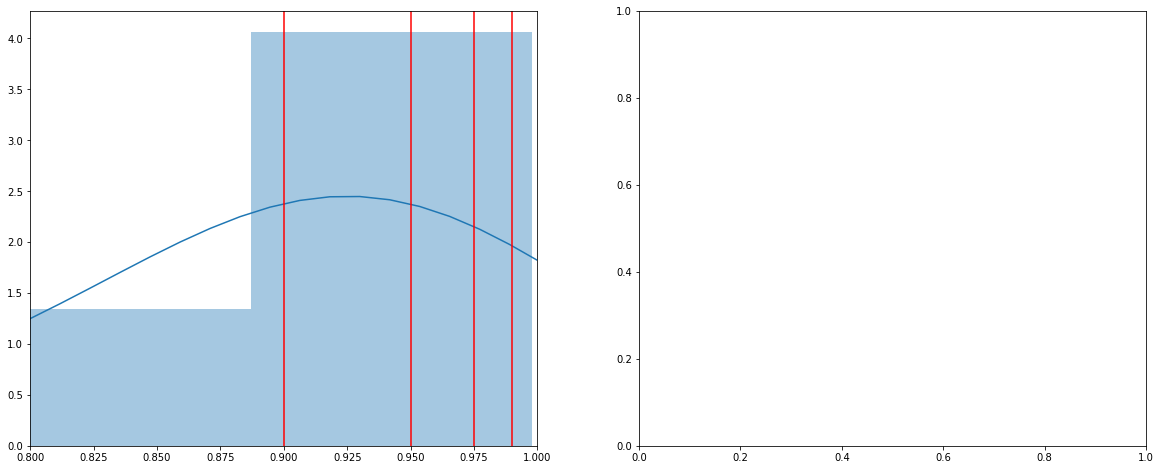

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.distplot(proc_df['idotp'].values)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.subplot(1,2,2)
sns.distplot(old_fits)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.show()
plt.close()

In [41]:
99268 / 4316

23.0

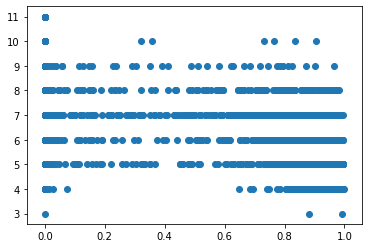

In [105]:
plt.scatter(proc_df['idotp'].values, proc_df['charge'].values)

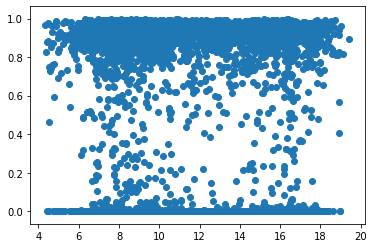

In [106]:
plt.scatter(list(proc_df['rt']), list(proc_df['idotp'].values))

In [120]:
old_fits = list(old_df['fit_to_theo_dist'].values)[::23]

In [150]:
old_rts = list(old_df['input_RTs'].values)[::23]

In [157]:
new_fits = list(proc_df['idotp'].values)

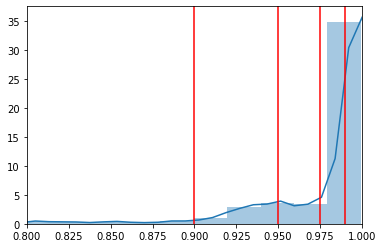

In [134]:
plt.figure()
sns.distplot(old_fits)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.show()
plt.close()

In [158]:
[len([x for x in new_fits if x > y]) for y in [0.9, 0.925, 0.95, 0.975, 0.99]]

[1801, 1386, 900, 313, 82]

In [136]:
[len([x for x in old_fits if x > y]) for y in [0.9, 0.925, 0.95, 0.975, 0.99]]

[1942, 1872, 1703, 1519, 1304]

In [144]:
rt_bins = []
for i,j in zip(range(4, 20), range(5, 21)):
    subdf = proc_df.loc[(proc_df['rt'] > i) & (proc_df['rt'] < j)]
    rt_bins.append(list(subdf.sort_values('rt')['idotp'].values))

In [145]:
len(rt_bins), len(range(4,21))

(16, 17)

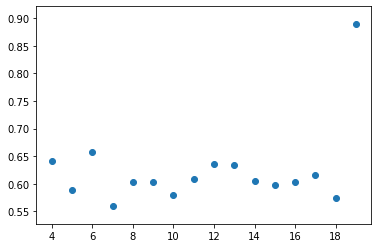

In [146]:
plt.scatter(range(4,20), [np.mean(rt) for rt in rt_bins])

In [ ]:
rt_bins = []
for i,j in zip(range(4, 20), range(5, 21)):

In [74]:
len(procdf.loc[procdf['idotp'] > 0.99])

72

In [48]:
proc_df.columns

Index(['index', 'name', 'charge', 'idotp'], dtype='object')

In [47]:
procdf = proc_df

In [36]:
library_info.columns

Index(['Unnamed: 0', 'name', 'RT', 'im_mono', 'ab_cluster_total', 'MW',
       'charge', 'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster', 'pred_RT',
       'UN', 'dup', 'sequence', 'idx', 'med_RT', 'RT_0_0', 'RT_0_1', 'RT_0_2',
       'RT_1_0', 'RT_2_0', 'RT_3_0', 'RT_4_0', 'RT_5_0', 'RT_6_0', 'RT_7_0',
       'RT_8_0', 'RT_9_0', 'RT_10_0', 'RT_11_0', 'RT_12_0', 'RT_13_0',
       'RT_14_0', 'RT_15_0', 'RT_16_0', 'RT_17_0', 'RT_18_0', 'RT_19_0',
       'RT_20_0', 'rt_group_mean_RT_0_0', 'rt_group_mean_RT_0_1',
       'rt_group_mean_RT_0_2', 'rt_group_mean_RT_1_0', 'rt_group_mean_RT_2_0',
       'rt_group_mean_RT_3_0', 'rt_group_mean_RT_4_0', 'rt_group_mean_RT_5_0',
       'rt_group_mean_RT_6_0', 'rt_group_mean_RT_7_0', 'rt_group_mean_RT_8_0',
       'rt_group_mean_RT_9_0', 'rt_group_mean_RT_10_0',
       'rt_group_mean_RT_11_0', 'rt_group_mean_RT_12_0',
       'rt_group_mean_RT_13_0', 'rt_group_mean_RT_14_0',
       'rt_group_mean_RT_15_0', 'rt_group_mean_RT_16_0',
       'rt_group_m

In [39]:
catdf['ab_cluster_total'].values[0]

46875.0

In [45]:
print(library_info.iloc[0].to_dict())

{'Unnamed: 0': 0, 'name': 'HHH_rd4_0891.pdb_4.33802', 'RT': 4.349177838693458, 'im_mono': 118.2256557181065, 'ab_cluster_total': 207025.7, 'MW': 5649.89215, 'charge': 5.0, 'expect_mz': 1130.9857, 'obs_mz': 1130.9862005079565, 'ppm': 0.4, 'abs_ppm': 0.4425411699315873, 'cluster': 139, 'pred_RT': 4.338017964071857, 'UN': 0, 'dup': False, 'sequence': 'HMDEEELLKDALRAYKEGDEDRLEEIVRRLNVDKKQVVDRAQRLEGSG', 'idx': 4173, 'med_RT': 4.338017964071857, 'RT_0_0': 4.3210818363273455, 'RT_0_1': 4.270273453093812, 'RT_0_2': 4.4057624750499, 'RT_1_0': 4.253337325349301, 'RT_2_0': 4.2025289421157686, 'RT_3_0': 4.23640119760479, 'RT_4_0': 4.168656686626747, 'RT_5_0': 4.23640119760479, 'RT_6_0': 4.3210818363273455, 'RT_7_0': 4.3210818363273455, 'RT_8_0': 4.388826347305389, 'RT_9_0': 4.185592814371256, 'RT_10_0': 4.185592814371256, 'RT_11_0': 4.270273453093812, 'RT_12_0': 4.3210818363273455, 'RT_13_0': 4.338017964071857, 'RT_14_0': 4.168656686626747, 'RT_15_0': 4.168656686626747, 'RT_16_0': 4.21946506986027

In [40]:
catdf.iloc[0]

name                EEHEE_rd1_0123.pdb
RT                             6.63273
im_mono                        81.9736
ab_cluster_total                 46875
MW                             4782.25
charge                               6
expect_mz                       798.05
obs_mz                         798.051
ppm                                1.4
abs_ppm                         1.3782
cluster                           3631
Name: 0, dtype: object

In [13]:
catdf.columns

Index(['name', 'RT', 'im_mono', 'ab_cluster_total', 'MW', 'charge',
       'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster'],
      dtype='object')

In [38]:
catdf = pd.concat([pd.read_csv(fn) for fn in sorted(glob.glob("resources/library_info/*_intermediate.csv"))])
catdf = catdf.sort_values(['name','charge','RT'])
catdf.index = range(len(catdf))

In [12]:
catdf

,name,RT,im_mono,ab_cluster_total,MW,charge,expect_mz,obs_mz,ppm,abs_ppm,cluster
0,EEHEE_rd1_0123.pdb,6.632732,81.973595,46875.0,4782.253953,6.0,798.049596,798.050695,1.4,1.378199,3631
1,EEHEE_rd1_0229.pdb,4.703894,109.573928,378912.8,5533.640409,4.0,1384.417372,1384.410288,-5.1,5.116900,1141
2,EEHEE_rd1_0229.pdb,4.840902,109.184688,343546.9,5533.640409,4.0,1384.417372,1384.424161,4.9,4.903972,1214
3,EEHEE_rd1_0229.pdb,4.738192,97.353775,908463.6,5533.640409,6.0,923.280672,923.278534,-2.3,2.315316,350
4,EEHEE_rd1_0229.pdb,4.860805,97.322173,1021822.2,5533.640409,6.0,923.280672,923.279136,-1.7,1.662935,1183
...,...,...,...,...,...,...,...,...,...,...,...
7143,HHH_rd4_1000.pdb,9.249983,93.823296,120403.3,5313.821553,5.0,1063.771581,1063.776613,4.7,4.730592,7349
7144,HHH_rd4_1000.pdb,7.671762,94.046766,910568.3,5313.821553,6.0,886.644196,886.639732,-5.0,5.034662,2192
7145,HHH_rd4_1000.pdb,7.682615,94.176751,523660.4,5313.821553,6.0,886.644196,886.642273,-2.2,2.167789,5070
7146,HHH_rd4_1000.pdb,7.812090,79.056210,830990.4,5313.821553,7.0,760.124635,760.122631,-2.6,2.635464,5048


In [4]:
hd_mass_diff = 1.006277
c13_mass_diff = 1.00335
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

In [5]:
olds =  glob.glob(old_data_dir+"*.pickle")

In [10]:
olds[0].split('/')[-1].split('_')[4:7]

['HEEH', 'rd2', '0682.pdb']

In [9]:
#make df of all old data
old_df = pd.DataFrame()
for fn in glob.glob(old_data_dir+"*.pickle"):
    #make hxprot representation per sequence
    ts = pickle.load(open(fn, 'rb'))
    name =  '_'.join(fn.split('/')[-1].split('_')[4:7])
    ts['name'] = name
    ts['charge'] = int(fn.split('.')[-3][-1])
    ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
    seq = names_and_seqs[names_and_seqs['name'].str.contains(name)]['sequence'].values[0]
    hx_prot = hxtools.hxprot(seq=seq)
    #Test fits to undeut
    undeut_amds = [{'major_species_integrated_intensities': ts['major_species_integrated_intensities'][i]} for i in range(3)]  
    ts['fit_to_theo_dist'] = max([hx_prot.calculate_isotope_dist(d) for d in undeut_amds])
    old_df = pd.concat([old_df, pd.DataFrame.from_dict(ts)])

In [20]:
len(old_df)/23

2123.0

In [25]:
old_df['charge'].values

array([5, 5, 5, ..., 5, 5, 5])

In [26]:
old_df.to_csv('resources/library_info/old_master_df.csv')

In [5]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')

In [17]:
%debug

> <ipython-input-16-b7d57ff6d3cf>(10)<module>()
      8     ts['charge'] = int(fn.split('.')[-3][-1])
      9     ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
---> 10     seq = names_and_seqs.loc[names_and_seqs['name'] == name]['sequence'].values[0]
     11     hx_prot = hxtools.hxprot(seq=seq)
     12     #Test fits to undeut



ipdb>  name


'HHH_rd1_0012.pdb'


ipdb>  names_and_seqs['name'].str.contains('rd1_0012')


0       False
1       False
2       False
3       False
4       False
        ...  
1319    False
1320    False
1321    False
1322    False
1323     True
Name: name, Length: 1324, dtype: bool


ipdb>  names_and_seqs[names_and_seqs['name'].str.contains('rd1_0012')]


      Unnamed: 0                    name  \
1323        1323  HHH_rd1_0012.pdb_SPIKE   

                                          raw_seq  \
1323  PEEDIKRKAKELLKEGNKEKAKRLLEKAGFSPDEAEQILNEIS   

                                             sequence  
1323  GSHMPEEDIKRKAKELLKEGNKEKAKRLLEKAGFSPDEAEQILNEIS  


ipdb>  quit


In [35]:
#open undeuterated files for each charge in master list and determine idotp
new_df = {}
old_df = {}
for i in range(len(library_info))[:1]:
    #make hxprot representation per sequence
    name = library_info.iloc[i]['name']
    charge = library_info.iloc[i]['charge']
    seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
    hx_prot = hxtools.hxprot(seq=seq)
    dot_products = []
    
    #Compute DataTensor init inputs
    max_peak_center = len(seq)
    total_isotopes = max_peak_center+high_mass_margin 
    total_mass_window = low_mass_margin+total_isotopes
    est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
    cum_peak_gaps = np.cumsum(est_peak_gaps)
    
    mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
    mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
    mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
    low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
    high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)
    
    #find rt_group undeut tensors
    undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]
    
    #test old undeut idotps
    #Find old files for charge, redundant, saves all old charges with same name regardless of RT
    old_files = sorted([fn for fn in glob.iglob(old_data_dir+"*.pickle") if "_".join(name.split("/")[-1].split("_")[:3]) in fn]) #hardcode 3 for undeut idxs
    print(len(old_files))
    if len(old_files) > 0:
        #Collect relevant values
        old_df[name] = []
        old_data = []
        for fn in old_files:
            ts = pickle.load(open(fn, 'rb'))
            ts['name'] = fn.split('/')[-1]
            ts['charge'] = int(fn.split('.')[-3][-1])
            ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
            old_data.append(ts)

        #Test fits to undeut
        for charge_dict in old_data:
            undeut_amds = [{'major_species_integrated_intensities': charge_dict['major_species_integrated_intensities'][i]} for i in range(3)]  
            charge_dict['fit_to_theo_dist'] = max([hx_prot.calculate_isotope_dist(d) for d in undeut_amds])
            old_df[name].append(pd.DataFrame.from_dict(charge_dict))
    else:
        old_df[name].append(pd.DataFrame())
        
    #start new undeut
    undeut_ics = []
    for fn in undeut_fns:
        #read mzml 
        output = hx.limit_read(fn)
    
        #make DataTensor
        newDataTensor = hx.DataTensor(
                                source_file = fn,
                                tensor_idx = i,
                                timepoint_idx = 0, 
                                name = name, 
                                total_mass_window = total_mass_window,
                                n_concatenated = 1,
                                charge_states = [library_info["charge"].values[i]], 
                                rts = output[0], 
                                dts= output[1], 
                                seq_out = output[2], 
                                int_seq_out = None
                                )
        
        newDataTensor.lows = np.searchsorted(newDataTensor.mz_bins, low_lims)
        newDataTensor.highs = np.searchsorted(newDataTensor.mz_bins, high_lims)
        newDataTensor.factorize()
        #Hacky, clean
        [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
    
    for ic in undeut_ics:
        df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
        fit = hx_prot.calculate_isotope_dist(df)
        ic.undeut_ground_dot_product = fit
        dot_products.append((fit, ic.charge_states))
    
    if len(dot_products) > 0:
        best_idotp = max(np.asarray(dot_products)[:,0])
    else: 
        best_idotp = 0
    
    print("I: "+str(i)+", Max charge idotp: "+str(best_idotp))

    new_df[name] = pd.DataFrame.from_dict({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]})
    print(old_df[name][0].keys())
    display(new_df[name])
    [display(df[['name','charge','fit_to_theo_dist', 'major_species_total_intensity']]) for df in old_df[name]]
    print(name+" idotp: "+str(best_idotp))
    print("Old idotps: "+str(old_df[name]['idotp'].values))
    

4
Beginning Factorization...
Done: T+6.057860612869263
Beginning Factorization...
Done: T+9.182021617889404
Beginning Factorization...
Done: T+9.717897653579712
I: 0, Max charge idotp: 0.964640663799057
Index(['output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')


,index,name,charge,idotp
0,0,HHH_rd4_0891.pdb_4.33802,5.0,0.964641


,name,charge,fit_to_theo_dist,major_species_total_intensity
0,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,548749.0
1,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,519414.0
2,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,514767.0
3,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,494020.0
4,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,489827.0
5,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,458503.0
6,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,509959.0
7,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,414326.0
8,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,439609.0
9,mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle,5,0.958226,487465.0


,name,charge,fit_to_theo_dist,major_species_total_intensity
0,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,1073172.0
1,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,1036325.0
2,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,934096.0
3,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,787852.0
4,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,755114.0
5,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,787197.0
6,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,806839.0
7,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,662333.0
8,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,773966.0
9,mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle,5,0.721479,814297.0


,name,charge,fit_to_theo_dist,major_species_total_intensity
0,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3793094.0
1,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3047148.0
2,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3135836.0
3,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3171420.0
4,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3152626.0
5,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,2733075.0
6,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,3092616.0
7,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,1808749.0
8,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,2227351.0
9,mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle,5,0.997902,2735052.0


,name,charge,fit_to_theo_dist,major_species_total_intensity
0,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,2282360.0
1,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,2182206.0
2,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1780429.0
3,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1713988.0
4,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1851393.0
5,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1589661.0
6,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1858508.0
7,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1291103.0
8,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1376120.0
9,mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle,6,0.961556,1713409.0


HHH_rd4_0891.pdb_4.33802 idotp: 0.964640663799057


TypeError: list indices must be integers or slices, not str

In [2]:
proc_files = glob.glob("resources/ic_time_series/*.cpickle.zlib")

In [3]:
proc_files[0].split('/')[-1].split('all')[0][:-1]

'HHH_rd2_0215.pdb_6.73279'

In [ ]:
for 

In [4]:
names = [fn.split('/')[-1].split('all')[0][:-1] for fn in proc_files]
for fn in proc_files:
    
    name = fn.split('/')[-1].split('all')[0][:-1]
    
    all_tp_clusters = hx.limit_read(fn)

    po = hx.PathOptimizer(name, all_tp_clusters, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "resources/old_data/")

    po.optimize_paths()

    source_frame, old_df = po.bokeh_plot("results/plots/"+name+"_time_series.html")

/projects/p30802/wes/hdx_analysis/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py:1995: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  old_df = pd.concat([ts_df, ic_df])


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=3753, glyph=Line(id='3751', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=3762, glyph=Line(id='3759', ...), ...)
/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rwl0960/.local/lib/python3.7/site-packages/scipy/stats/stats.py:333: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=11526, glyph=Line(id='11524', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=11535, glyph=Line(id='11532', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=19299, glyph=Line(id='19297', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=19308, glyph=Line(id='19305', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=27072, glyph=Line(id='27070', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=27081, glyph=Line(id='27078', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=34845, glyph=Line(id='34843', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=34854, glyph=Line(id='34851', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=42618, glyph=Line(id='42616', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=42627, glyph=Line(id='42624', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=50391, glyph=Line(id='50389', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=50400, glyph=Line(id='50397', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=58164, glyph=Line(id='58162', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=58173, glyph=Line(id='58170', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=65937, glyph=Line(id='65935', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=65946, glyph=Line(id='65943', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=73710, glyph=Line(id='73708', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=73719, glyph=Line(id='73716', ...), ...)


len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.p

ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=81483, glyph=Line(id='81481', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=81492, glyph=Line(id='81489', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=89256, glyph=Line(id='89254', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=89265, glyph=Line(id='89262', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=97029, glyph=Line(id='97027', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=97038, glyph=Line(id='97035', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=104802, glyph=Line(id='104800', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=104811, glyph=Line(id='104808', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=112575, glyph=Line(id='112573', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=112584, glyph=Line(id='112581', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=120348, glyph=Line(id='120346', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=120357, glyph=Line(id='120354', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=128121, glyph=Line(id='128119', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=128130, glyph=Line(id='128127', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=135894, glyph=Line(id='135892', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=135903, glyph=Line(id='135900', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=143667, glyph=Line(id='143665', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=143676, glyph=Line(id='143673', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=151440, glyph=Line(id='151438', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=151449, glyph=Line(id='151446', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=159213, glyph=Line(id='159211', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=159222, glyph=Line(id='159219', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=166986, glyph=Line(id='166984', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=166995, glyph=Line(id='166992', ...), ...)


In [ ]:
%debug

> /projects/p30802/wes/hdx_analysis/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(1479)clusters_close_to_line()
   1477                         import sys
   1478                         sys.stdout.write("len(PO.prefiltered_ics["+str(tp)+"]) == 0")
-> 1479                         os.kill(os.getpid())
   1480 
   1481 



In [9]:
flat = []
proc_buf = []
for fn in proc_files:
    fn_buf = []
    tps = hx.limit_read(fn)
    for tp in tps:
        if len(tp) > 0:
            ic = tp[0]
            flat.append(ic.n_factors)
            fn_buf.append(ic.n_factors)
        else:
            pass
    proc_buf.append(fn_buf)

In [10]:
sflat = sorted(flat)

In [11]:
counts = ddict().fromkeys(sflat)
for i in sflat:
    if counts[i] is None:
        counts[i] = 1
    else:
        counts[i] += 1

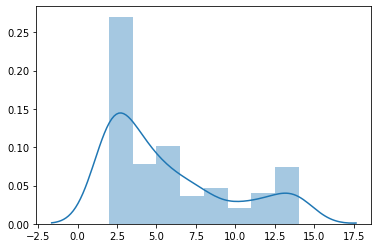

In [12]:
sns.distplot(sflat)

In [8]:
conda list

# packages in environment at /home/rwl0960/.conda/envs/dask_lab:
#
_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                  

In [33]:
nb_conda_list = """_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                    py37_0  
boto3                     1.11.0                     py_0    conda-forge
botocore                  1.14.0                     py_0    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.8.28                     0  
cachetools                3.1.1                      py_0    conda-forge
cairo                     1.14.12              h8948797_3  
certifi                   2019.9.11                py37_0  
cffi                      1.13.2           py37h8022711_0    conda-forge
chardet                   3.0.4                 py37_1003    conda-forge
click                     7.0                      py37_0  
cloudpickle               1.2.2                      py_0  
configargparse            0.13.0                     py_1    conda-forge
cookiecutter              1.7.0                      py_0    conda-forge
cryptography              2.8              py37h72c5cf5_1    conda-forge
cycler                    0.10.0                   py37_0  
cytoolz                   0.10.0           py37h7b6447c_0  
dask                      2.5.2                      py_0  
dask-core                 2.5.2                      py_0  
datrie                    0.8              py37h516909a_0    conda-forge
dbus                      1.13.6               h746ee38_0  
decorator                 4.4.0                    py37_1  
defusedxml                0.6.0                      py_0  
distributed               2.5.2                      py_0  
docutils                  0.15.2                   py37_0    conda-forge
dropbox                   9.4.0                      py_0    conda-forge
entrypoints               0.3                      py37_0  
expat                     2.2.6                he6710b0_0  
fastdtw                   0.2.0                      py_1    bioconda
fftw                      3.3.8           nompi_h7f3a6c3_1110    conda-forge
filechunkio               1.8                        py_2    conda-forge
fontconfig                2.13.0               h9420a91_0  
freetype                  2.9.1                h8a8886c_1  
fsspec                    0.5.1                      py_0  
ftputil                   3.4                        py_0    conda-forge
future                    0.18.2                   py37_0    conda-forge
gettext                   0.19.8.1          hc5be6a0_1002    conda-forge
ghostscript               9.18                          1    bioconda
giflib                    5.1.9                h516909a_0    conda-forge
gitdb2                    2.0.6                      py_0    conda-forge
gitpython                 3.0.5                      py_0    conda-forge
glib                      2.56.2               hd408876_0  
gmp                       6.1.2                h6c8ec71_1  
google-api-core           1.15.0                   py37_0    conda-forge
google-auth               1.10.0                     py_0    conda-forge
google-cloud-core         1.1.0                      py_0    conda-forge
google-cloud-storage      1.24.1                   py37_0    conda-forge
google-resumable-media    0.5.0                      py_0    conda-forge
googleapis-common-protos  1.6.0                    py37_0    conda-forge
graphite2                 1.3.13            hf484d3e_1000    conda-forge
graphviz                  2.38.0            hcf1ce16_1009    conda-forge
gst-plugins-base          1.14.0               hbbd80ab_1  
gstreamer                 1.14.0               hb453b48_1  
harfbuzz                  1.9.0             he243708_1001    conda-forge
heapdict                  1.0.1                      py_0  
icu                       58.2                 h9c2bf20_1  
idna                      2.8                   py37_1000    conda-forge
imagemagick               7.0.8_11        pl526hc610aec_0    conda-forge
intel-openmp              2019.4                      243  
ipdb                      0.12.3                    <pip>
ipykernel                 5.1.2            py37h39e3cac_0  
ipython                   7.8.0            py37h39e3cac_0  
ipython_genutils          0.2.0                    py37_0  
jbig                      2.1               h14c3975_2001    conda-forge
jedi                      0.15.1                   py37_0  
jinja2                    2.10.1                   py37_0  
jinja2-time               0.2.0                      py_2    conda-forge
jmespath                  0.9.4                      py_0    conda-forge
joblib                    0.14.0                     py_0  
jpeg                      9c                h14c3975_1001    conda-forge
json5                     0.8.5                      py_0  
jsonschema                3.0.2                    py37_0  
jupyter_client            5.3.3                    py37_1  
jupyter_core              4.5.0                      py_0  
jupyterlab                1.1.4              pyhf63ae98_0  
jupyterlab_server         1.0.6                      py_0  
kiwisolver                1.1.0            py37he6710b0_0  
libedit                   3.1.20181209         hc058e9b_0  
libffi                    3.2.1                hd88cf55_4  
libgcc                    7.2.0                h69d50b8_2    conda-forge
libgcc-ng                 9.1.0                hdf63c60_0  
libgfortran-ng            7.3.0                hdf63c60_0  
libpng                    1.6.37               hbc83047_0  
libprotobuf               3.11.2               h8b12597_0    conda-forge
libsodium                 1.0.16               h1bed415_0  
libstdcxx-ng              9.1.0                hdf63c60_0  
libtiff                   4.0.10               h2733197_2  
libtool                   2.4.6             h14c3975_1002    conda-forge
libuuid                   1.0.3                h1bed415_2  
libwebp                   0.5.2                         7    conda-forge
libxcb                    1.13                 h1bed415_1  
libxml2                   2.9.9                hea5a465_1  
locket                    0.2.0                    py37_1  
markupsafe                1.1.1            py37h7b6447c_0  
matplotlib                3.1.1            py37h5429711_0  
mistune                   0.8.4            py37h7b6447c_0  
mkl                       2019.4                      243  
mkl-service               2.3.0            py37he904b0f_0  
mkl_fft                   1.0.14           py37ha843d7b_0  
mkl_random                1.1.0            py37hd6b4f25_0  
msgpack-python            0.6.1            py37hfd86e86_1  
multidict                 4.7.3            py37h516909a_0    conda-forge
nbconvert                 5.6.0                    py37_1  
nbformat                  4.4.0                    py37_0  
ncurses                   6.1                  he6710b0_1  
networkx                  2.4                        py_0    conda-forge
nodejs                    10.13.0              he6710b0_0  
notebook                  6.0.1                    py37_0  
numpy                     1.17.2           py37haad9e8e_0  
numpy-base                1.17.2           py37hde5b4d6_0  
olefile                   0.46                     py37_0  
openjpeg                  2.3.1                h21c5421_1    conda-forge
openssl                   1.1.1d               h7b6447c_2  
packaging                 19.2                       py_0  
pandas                    0.25.1           py37he6710b0_0  
pandoc                    2.2.3.2                       0  
pandocfilters             1.4.2                    py37_1  
pango                     1.40.14              he752989_2    conda-forge
paramiko                  2.7.1                    py37_0    conda-forge
parso                     0.5.1                      py_0  
partd                     1.0.0                      py_0  
patsy                     0.5.1                    py37_0  
pcre                      8.43                 he6710b0_0  
perl                      5.26.2            h516909a_1006    conda-forge
pexpect                   4.7.0                    py37_0  
pickleshare               0.7.5                    py37_0  
pillow                    6.1.0            py37h34e0f95_0  
pip                       19.2.3                   py37_0  
pixman                    0.38.0            h516909a_1003    conda-forge
pkg-config                0.29.2            h516909a_1006    conda-forge
poyo                      0.5.0                      py_0    conda-forge
prettytable               0.7.2                      py_3    conda-forge
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py37_0  
protobuf                  3.11.2           py37he1b5a44_0    conda-forge
psutil                    5.6.3            py37h7b6447c_0  
ptyprocess                0.6.0                    py37_0  
pyasn1                    0.4.8                      py_0    conda-forge
pyasn1-modules            0.2.7                      py_0    conda-forge
pycparser                 2.19                     py37_1    conda-forge
pygments                  2.4.2                      py_0  
pygraphviz                1.5             py37h516909a_1001    conda-forge
pynacl                    1.3.0           py37h516909a_1001    conda-forge
pyopenssl                 19.1.0                   py37_0    conda-forge
pyparsing                 2.4.2                      py_0  
pypdf2                    1.26.0                     py_2    conda-forge
pyqt                      5.9.2            py37h05f1152_2  
pyrsistent                0.15.4           py37h7b6447c_0  
pysftp                    0.2.9                      py_1    conda-forge
pysocks                   1.7.1                    py37_0    conda-forge
python                    3.7.4                h265db76_1  
python-dateutil           2.8.0                    py37_0  
python-irodsclient        0.7.0                      py_0    conda-forge
pytz                      2019.2                     py_0  
pyyaml                    5.1.2            py37h7b6447c_0  
pyzmq                     18.1.0           py37he6710b0_0  
qt                        5.9.7                h5867ecd_1  
ratelimiter               1.2.0                 py37_1000    conda-forge
readline                  7.0                  h7b6447c_5  
requests                  2.22.0                   py37_1    conda-forge
rsa                       4.0                        py_0    conda-forge
s3transfer                0.3.0                    py37_0    conda-forge
scikit-learn              0.21.3           py37hd81dba3_0  
scipy                     1.5.2            py37h0b6359f_0  
seaborn                   0.9.0                    py37_0  
send2trash                1.5.0                    py37_0  
setuptools                41.2.0                   py37_0  
simanneal                 0.4.2                      py_0    conda-forge
sip                       4.19.8           py37hf484d3e_0  
six                       1.12.0                   py37_0  
smmap2                    2.0.5                      py_0    conda-forge
snakemake                 5.9.1                         0    bioconda
snakemake-minimal         5.9.1                      py_0    bioconda
sortedcontainers          2.1.0                    py37_0  
sqlite                    3.30.0               h7b6447c_0  
statsmodels               0.10.1           py37hdd07704_0  
tblib                     1.4.0                      py_0  
terminado                 0.8.2                    py37_0  
testpath                  0.4.2                    py37_0  
tk                        8.6.8                hbc83047_0  
toolz                     0.10.0                     py_0  
tornado                   6.0.3            py37h7b6447c_0  
traitlets                 4.3.2                    py37_0  
typing_extensions         3.7.4.1                  py37_0  
urllib3                   1.25.7                   py37_0    conda-forge
wcwidth                   0.1.7                    py37_0  
webencodings              0.5.1                    py37_1  
wheel                     0.33.6                   py37_0  
whichcraft                0.6.1                      py_0    conda-forge
wrapt                     1.11.2           py37h516909a_0    conda-forge
xmlrunner                 1.7.7                      py_0    conda-forge
xorg-kbproto              1.0.7             h14c3975_1002    conda-forge
xorg-libice               1.0.10               h516909a_0    conda-forge
xorg-libsm                1.2.2                h470a237_5    conda-forge
xorg-libx11               1.6.9                h516909a_0    conda-forge
xorg-libxext              1.3.4                h516909a_0    conda-forge
xorg-libxpm               3.5.13               h516909a_0    conda-forge
xorg-libxrender           0.9.10            h516909a_1002    conda-forge
xorg-libxt                1.1.5             h516909a_1003    conda-forge
xorg-renderproto          0.11.1            h14c3975_1002    conda-forge
xorg-xextproto            7.3.0             h14c3975_1002    conda-forge
xorg-xproto               7.0.31            h14c3975_1007    conda-forge
xz                        5.2.4                h14c3975_4  
yaml                      0.1.7                had09818_2  
yarl                      1.3.0           py37h516909a_1000    conda-forge
zeromq                    4.3.1                he6710b0_3  
zict                      1.0.0                      py_0  
zlib                      1.2.11               h7b6447c_3  
zstd                      1.3.7                h0b5b093_0  """

term_conda_list = """_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                    py37_0  
boto3                     1.11.0                     py_0    conda-forge
botocore                  1.14.0                     py_0    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.8.28                     0  
cachetools                3.1.1                      py_0    conda-forge
cairo                     1.14.12              h8948797_3  
certifi                   2019.9.11                py37_0  
cffi                      1.13.2           py37h8022711_0    conda-forge
chardet                   3.0.4                 py37_1003    conda-forge
click                     7.0                      py37_0  
cloudpickle               1.2.2                      py_0  
configargparse            0.13.0                     py_1    conda-forge
cookiecutter              1.7.0                      py_0    conda-forge
cryptography              2.8              py37h72c5cf5_1    conda-forge
cycler                    0.10.0                   py37_0  
cytoolz                   0.10.0           py37h7b6447c_0  
dask                      2.5.2                      py_0  
dask-core                 2.5.2                      py_0  
datrie                    0.8              py37h516909a_0    conda-forge
dbus                      1.13.6               h746ee38_0  
decorator                 4.4.0                    py37_1  
defusedxml                0.6.0                      py_0  
distributed               2.5.2                      py_0  
docutils                  0.15.2                   py37_0    conda-forge
dropbox                   9.4.0                      py_0    conda-forge
entrypoints               0.3                      py37_0  
expat                     2.2.6                he6710b0_0  
fastdtw                   0.2.0                      py_1    bioconda
fftw                      3.3.8           nompi_h7f3a6c3_1110    conda-forge
filechunkio               1.8                        py_2    conda-forge
fontconfig                2.13.0               h9420a91_0  
freetype                  2.9.1                h8a8886c_1  
fsspec                    0.5.1                      py_0  
ftputil                   3.4                        py_0    conda-forge
future                    0.18.2                   py37_0    conda-forge
gettext                   0.19.8.1          hc5be6a0_1002    conda-forge
ghostscript               9.18                          1    bioconda
giflib                    5.1.9                h516909a_0    conda-forge
gitdb2                    2.0.6                      py_0    conda-forge
gitpython                 3.0.5                      py_0    conda-forge
glib                      2.56.2               hd408876_0  
gmp                       6.1.2                h6c8ec71_1  
google-api-core           1.15.0                   py37_0    conda-forge
google-auth               1.10.0                     py_0    conda-forge
google-cloud-core         1.1.0                      py_0    conda-forge
google-cloud-storage      1.24.1                   py37_0    conda-forge
google-resumable-media    0.5.0                      py_0    conda-forge
googleapis-common-protos  1.6.0                    py37_0    conda-forge
graphite2                 1.3.13            hf484d3e_1000    conda-forge
graphviz                  2.38.0            hcf1ce16_1009    conda-forge
gst-plugins-base          1.14.0               hbbd80ab_1  
gstreamer                 1.14.0               hb453b48_1  
harfbuzz                  1.9.0             he243708_1001    conda-forge
heapdict                  1.0.1                      py_0  
icu                       58.2                 h9c2bf20_1  
idna                      2.8                   py37_1000    conda-forge
imagemagick               7.0.8_11        pl526hc610aec_0    conda-forge
intel-openmp              2019.4                      243  
ipdb                      0.12.3                    <pip>
ipykernel                 5.1.2            py37h39e3cac_0  
ipython                   7.8.0            py37h39e3cac_0  
ipython_genutils          0.2.0                    py37_0  
jbig                      2.1               h14c3975_2001    conda-forge
jedi                      0.15.1                   py37_0  
jinja2                    2.10.1                   py37_0  
jinja2-time               0.2.0                      py_2    conda-forge
jmespath                  0.9.4                      py_0    conda-forge
joblib                    0.14.0                     py_0  
jpeg                      9c                h14c3975_1001    conda-forge
json5                     0.8.5                      py_0  
jsonschema                3.0.2                    py37_0  
jupyter_client            5.3.3                    py37_1  
jupyter_core              4.5.0                      py_0  
jupyterlab                1.1.4              pyhf63ae98_0  
jupyterlab_server         1.0.6                      py_0  
kiwisolver                1.1.0            py37he6710b0_0  
libedit                   3.1.20181209         hc058e9b_0  
libffi                    3.2.1                hd88cf55_4  
libgcc                    7.2.0                h69d50b8_2    conda-forge
libgcc-ng                 9.1.0                hdf63c60_0  
libgfortran-ng            7.3.0                hdf63c60_0  
libpng                    1.6.37               hbc83047_0  
libprotobuf               3.11.2               h8b12597_0    conda-forge
libsodium                 1.0.16               h1bed415_0  
libstdcxx-ng              9.1.0                hdf63c60_0  
libtiff                   4.0.10               h2733197_2  
libtool                   2.4.6             h14c3975_1002    conda-forge
libuuid                   1.0.3                h1bed415_2  
libwebp                   0.5.2                         7    conda-forge
libxcb                    1.13                 h1bed415_1  
libxml2                   2.9.9                hea5a465_1  
locket                    0.2.0                    py37_1  
markupsafe                1.1.1            py37h7b6447c_0  
matplotlib                3.1.1            py37h5429711_0  
mistune                   0.8.4            py37h7b6447c_0  
mkl                       2019.4                      243  
mkl-service               2.3.0            py37he904b0f_0  
mkl_fft                   1.0.14           py37ha843d7b_0  
mkl_random                1.1.0            py37hd6b4f25_0  
msgpack-python            0.6.1            py37hfd86e86_1  
multidict                 4.7.3            py37h516909a_0    conda-forge
nbconvert                 5.6.0                    py37_1  
nbformat                  4.4.0                    py37_0  
ncurses                   6.1                  he6710b0_1  
networkx                  2.4                        py_0    conda-forge
nodejs                    10.13.0              he6710b0_0  
notebook                  6.0.1                    py37_0  
numpy                     1.17.2           py37haad9e8e_0  
numpy-base                1.17.2           py37hde5b4d6_0  
olefile                   0.46                     py37_0  
openjpeg                  2.3.1                h21c5421_1    conda-forge
openssl                   1.1.1d               h7b6447c_2  
packaging                 19.2                       py_0  
pandas                    0.25.1           py37he6710b0_0  
pandoc                    2.2.3.2                       0  
pandocfilters             1.4.2                    py37_1  
pango                     1.40.14              he752989_2    conda-forge
paramiko                  2.7.1                    py37_0    conda-forge
parso                     0.5.1                      py_0  
partd                     1.0.0                      py_0  
patsy                     0.5.1                    py37_0  
pcre                      8.43                 he6710b0_0  
perl                      5.26.2            h516909a_1006    conda-forge
pexpect                   4.7.0                    py37_0  
pickleshare               0.7.5                    py37_0  
pillow                    6.1.0            py37h34e0f95_0  
pip                       19.2.3                   py37_0  
pixman                    0.38.0            h516909a_1003    conda-forge
pkg-config                0.29.2            h516909a_1006    conda-forge
poyo                      0.5.0                      py_0    conda-forge
prettytable               0.7.2                      py_3    conda-forge
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py37_0  
protobuf                  3.11.2           py37he1b5a44_0    conda-forge
psutil                    5.6.3            py37h7b6447c_0  
ptyprocess                0.6.0                    py37_0  
pyasn1                    0.4.8                      py_0    conda-forge
pyasn1-modules            0.2.7                      py_0    conda-forge
pycparser                 2.19                     py37_1    conda-forge
pygments                  2.4.2                      py_0  
pygraphviz                1.5             py37h516909a_1001    conda-forge
pynacl                    1.3.0           py37h516909a_1001    conda-forge
pyopenssl                 19.1.0                   py37_0    conda-forge
pyparsing                 2.4.2                      py_0  
pypdf2                    1.26.0                     py_2    conda-forge
pyqt                      5.9.2            py37h05f1152_2  
pyrsistent                0.15.4           py37h7b6447c_0  
pysftp                    0.2.9                      py_1    conda-forge
pysocks                   1.7.1                    py37_0    conda-forge
python                    3.7.4                h265db76_1  
python-dateutil           2.8.0                    py37_0  
python-irodsclient        0.7.0                      py_0    conda-forge
pytz                      2019.2                     py_0  
pyyaml                    5.1.2            py37h7b6447c_0  
pyzmq                     18.1.0           py37he6710b0_0  
qt                        5.9.7                h5867ecd_1  
ratelimiter               1.2.0                 py37_1000    conda-forge
readline                  7.0                  h7b6447c_5  
requests                  2.22.0                   py37_1    conda-forge
rsa                       4.0                        py_0    conda-forge
s3transfer                0.3.0                    py37_0    conda-forge
scikit-learn              0.21.3           py37hd81dba3_0  
scipy                     1.5.2            py37h0b6359f_0  
seaborn                   0.9.0                    py37_0  
send2trash                1.5.0                    py37_0  
setuptools                41.2.0                   py37_0  
simanneal                 0.4.2                      py_0    conda-forge
sip                       4.19.8           py37hf484d3e_0  
six                       1.12.0                   py37_0  
smmap2                    2.0.5                      py_0    conda-forge
snakemake                 5.9.1                         0    bioconda
snakemake-minimal         5.9.1                      py_0    bioconda
sortedcontainers          2.1.0                    py37_0  
sqlite                    3.30.0               h7b6447c_0  
statsmodels               0.10.1           py37hdd07704_0  
tblib                     1.4.0                      py_0  
terminado                 0.8.2                    py37_0  
testpath                  0.4.2                    py37_0  
tk                        8.6.8                hbc83047_0  
toolz                     0.10.0                     py_0  
tornado                   6.0.3            py37h7b6447c_0  
traitlets                 4.3.2                    py37_0  
typing_extensions         3.7.4.1                  py37_0  
urllib3                   1.25.7                   py37_0    conda-forge
wcwidth                   0.1.7                    py37_0  
webencodings              0.5.1                    py37_1  
wheel                     0.33.6                   py37_0  
whichcraft                0.6.1                      py_0    conda-forge
wrapt                     1.11.2           py37h516909a_0    conda-forge
xmlrunner                 1.7.7                      py_0    conda-forge
xorg-kbproto              1.0.7             h14c3975_1002    conda-forge
xorg-libice               1.0.10               h516909a_0    conda-forge
xorg-libsm                1.2.2                h470a237_5    conda-forge
xorg-libx11               1.6.9                h516909a_0    conda-forge
xorg-libxext              1.3.4                h516909a_0    conda-forge
xorg-libxpm               3.5.13               h516909a_0    conda-forge
xorg-libxrender           0.9.10            h516909a_1002    conda-forge
xorg-libxt                1.1.5             h516909a_1003    conda-forge
xorg-renderproto          0.11.1            h14c3975_1002    conda-forge
xorg-xextproto            7.3.0             h14c3975_1002    conda-forge
xorg-xproto               7.0.31            h14c3975_1007    conda-forge
xz                        5.2.4                h14c3975_4  
yaml                      0.1.7                had09818_2  
yarl                      1.3.0           py37h516909a_1000    conda-forge
zeromq                    4.3.1                he6710b0_3  
zict                      1.0.0                      py_0  
zlib                      1.2.11               h7b6447c_3  
zstd                      1.3.7                h0b5b093_0  """

In [34]:
nb_lib_vers = [[j for j in i.split(' ') if j is not ''][:2] for i in nb_conda_list.split("\n")]
nb_libs = [i[0] for i in nb_lib_vers]

term_lib_vers = [[j for j in i.split(' ') if j is not ''][:2] for i in term_conda_list.split("\n")]
term_libs = [i[0] for i in term_lib_vers]

In [36]:
version_dict = ddict()
for i in nb_lib_vers:
    version_dict[i[0]] = i[1]

In [38]:
keys = version_dict.keys()
for i in term_lib_vers:
    if i[0] in keys:
        if version_dict[i[0]] == i[1]:
            pass
        else:
            print('version_mismatch: '+i[0])
    else:
        print('module mismatch: '+i[0])

In [2]:
1800/25*8/60

9.6

In [3]:
lines = [line]

In [4]:
#Generate rt-group ics
for line in lines:
    paths = glob.glob("resources/tensors/"+str(line)+"_*")    
    tp_inputs = [[fn for fn in paths if tp_name in fn] for tp_name in tp_names]
    name = library_info.iloc[line]['name']

    t = hx.TensorGenerator(name, library_info, tp_inputs, timepoints)
    t.generate_tensors()
    hx.limit_write(t.all_tp_clusters, "resources/ic_time_series/"+t.name+"_all_tp_clusters.cpickle.zlib")

Starting 0 seconds, 1 of 21
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib, 1 of 3
File: resources/tensors/0_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib
Reprofiling...
T+1.4698243141174316
Beginning Factorization...
Filtering... T+0.00021910667419433594
Zeroing Non-POI M/z... T+0.0003180503845214844
Start Factorization Series... T+0.0050373077392578125
Starting 14 Factors... T+0.0002548694610595703
Factorization Duration: 2.197138786315918
Starting 13 Factors... T+2.1986067295074463
Factorization Duration: 2.0444602966308594
Starting 12 Factors... T+4.244719982147217
Factorization Duration: 1.8798737525939941
Starting 11 Factors... T+6.125582695007324
Factorization Duration: 1.747236728668213
Starting 10 Factors... T+7.873871088027954
Factorization Duration: 1.62093186378479
Saving Factor Objects... T+9.501122236251831
Done: T+9.516995429992676
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib, 2 of 3
File: resources/tens

In [25]:
for tp in t.all_tp_clusters:
    print(len(tp))

NameError: name 't' is not defined

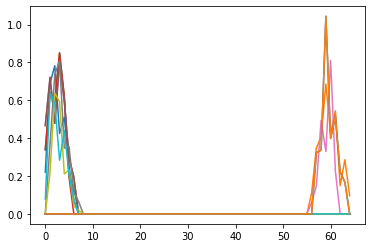

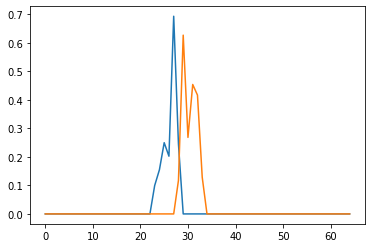

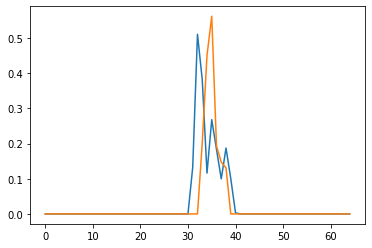

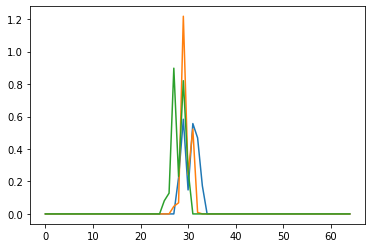

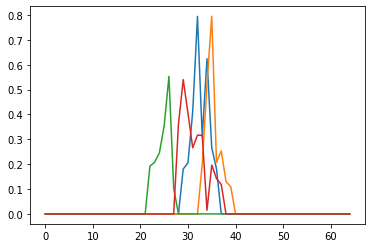

<Figure size 432x288 with 0 Axes>

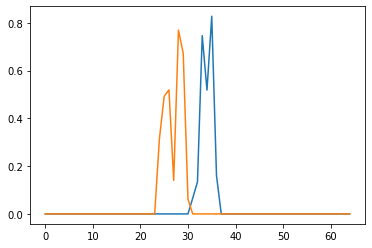

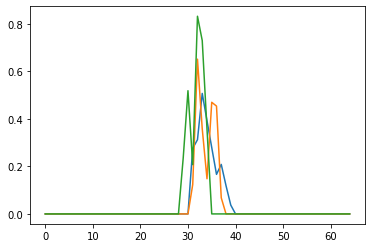

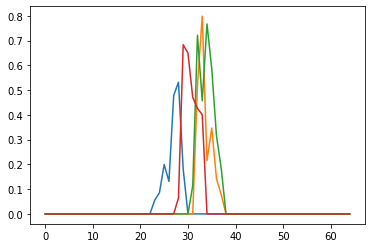

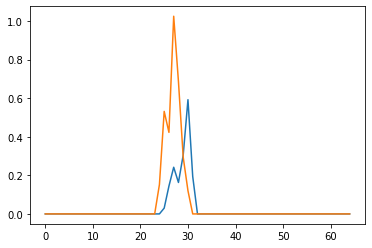

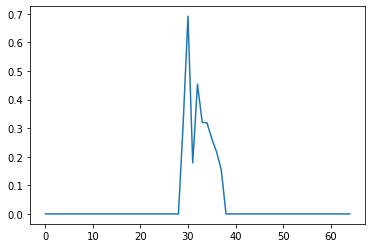

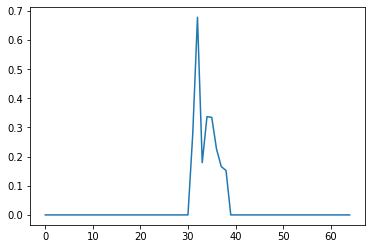

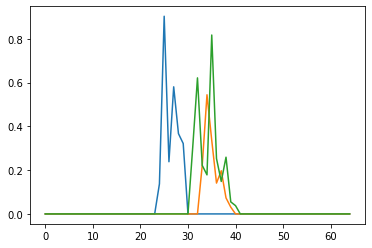

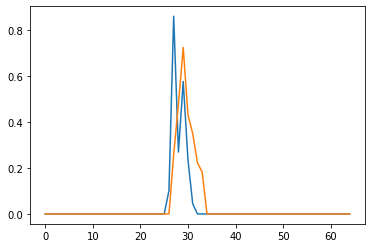

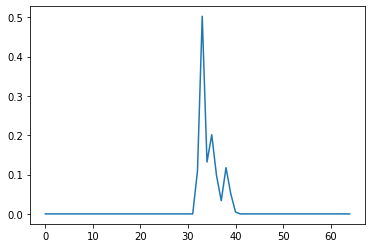

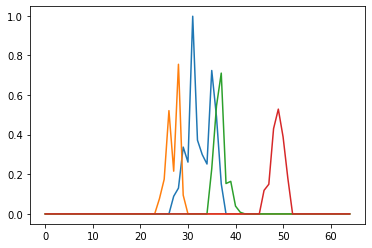

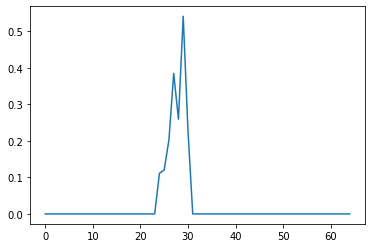

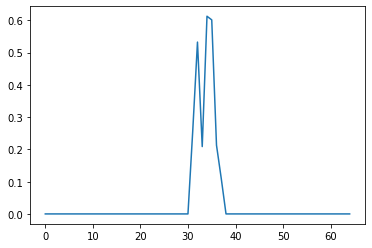

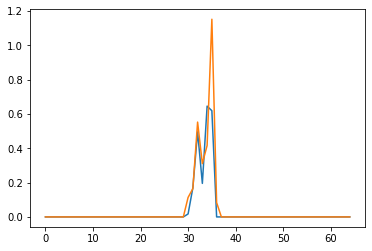

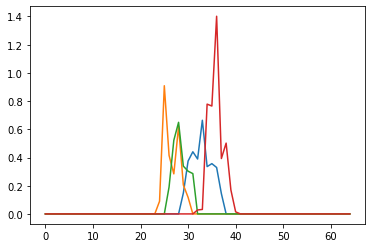

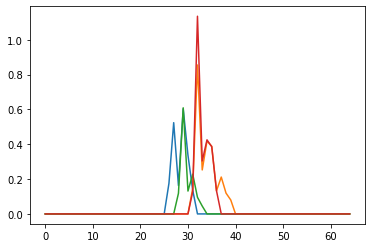

In [5]:
for tp in t.all_tp_clusters:
    plt.figure()
    for ic in tp:
        plt.plot(ic.baseline_integrated_mz)
    plt.show()
    plt.close()

In [ ]:
#PO and bokeh plot
for line in subset_indices[:2]:
    
    name = library_info.iloc[line]['name']
    
    all_tp_clusters = hx.limit_read("data/ic_time_series/"+library_info.iloc[line]['name']+"_all_tp_clusters.cpickle.zlib")
    
    po = hx.PathOptimizer(name, all_tp_clusters, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "/Users/rwl0960/Documents/hdx/local_LIMIT/data/old_data/")

    po.optimize_paths()

    source_frame, old_df = po.bokeh_plot("plots/"+name+"_time_series.html")